## Digit Recognizer
https://www.kaggle.com/c/digit-recognizer

In [1]:
%matplotlib inline
import cv2
import numpy as np
import matplotlib.pyplot as plt

## Загружаем исходные данные

In [2]:
train = np.loadtxt('./data/digit/train.csv', delimiter=',', skiprows=1)
test = np.loadtxt('./data/digit/test.csv', delimiter=',', skiprows=1)

In [3]:
# сохраняем разметку в отдельную переменную
train_label = train[:, 0]
# приводим размерность к удобному для обаботки виду
train_img = np.resize(train[:, 1:], (train.shape[0], 28, 28))
test_img = np.resize(test, (test.shape[0], 28, 28))

In [4]:
test_img.shape

(28000, 28, 28)

## Визуализируем исходные данные

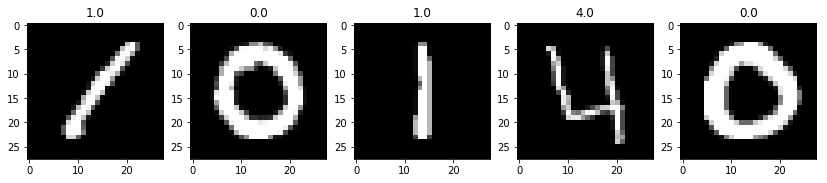

In [5]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(train_img[0:5], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % train_label[i - 1]);

In [6]:
train_img=train_img.reshape(-1, 28 * 28).astype(np.float32)
train_img_mean = train_img.mean(axis=0)
train_img -= train_img_mean
cov = np.dot(train_img.T, train_img) / train_img.shape[0]
U, S, _ = np.linalg.svd(cov)
S_cumsum = np.cumsum(S) / np.sum(S)
S_thr = 0.75
n_comp = np.argmax(np.where(S_cumsum > S_thr, 1, 0))

print('n_comp=%d S=%.3f' % (n_comp, S_cumsum[n_comp]))

n_comp=32 S=0.751


In [7]:
train_img_reduced = np.dot(train_img, U[:, :n_comp])
train_img = np.dot(train_img_reduced, U[:,:n_comp].T)

In [8]:
test_img=test_img.reshape(-1, 28 * 28).astype(np.float32)
test_img_mean = test_img.mean(axis=0)
test_img -= test_img_mean
cov = np.dot(test_img.T, test_img) / test_img.shape[0]
U, S, _ = np.linalg.svd(cov)
S_cumsum = np.cumsum(S) / np.sum(S)
S_thr = 0.85
n_comp = np.argmax(np.where(S_cumsum > S_thr, 1, 0))

print('n_comp=%d S=%.3f' % (n_comp, S_cumsum[n_comp]))

n_comp=58 S=0.851


In [9]:
test_img_reduced = np.dot(test_img, U[:, :n_comp])
test_img = np.dot(test_img_reduced, U[:,:n_comp].T)

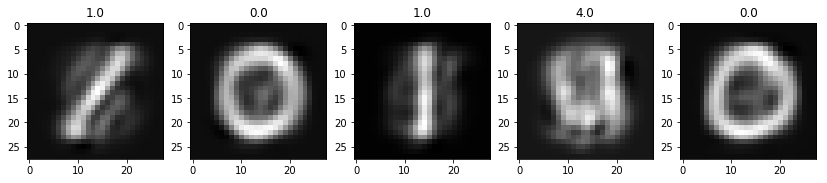

In [10]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(train_img[0:5], 1):
    subplot = fig.add_subplot(1, 7, i)
    img_ = img + train_img_mean
    plt.title('%s' % train_label[i-1])
    plt.imshow(img_.reshape((28,28)) + train_img_mean.reshape((28,28)), cmap='gray');

## Разбиваем выборку на обучение и валидацию

In [11]:
from sklearn.model_selection import train_test_split
y_train, y_val, x_train, x_val = train_test_split(
    train_label, train_img, test_size=0.2,
    random_state=42)

In [12]:
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier(n_neighbors=10)

In [13]:
model.fit(x_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=10, p=2,
           weights='uniform')

In [14]:
pred_val=model.predict(x_val)

## Оцениваем качество решение на валидационной выборке

In [15]:
from sklearn.metrics import accuracy_score
print('Accuracy: %s' % accuracy_score(y_val, pred_val))

Accuracy: 0.9686904761904762


In [16]:
from sklearn.metrics import classification_report
print(classification_report(y_val, pred_val))

              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99       816
         1.0       0.96      1.00      0.98       909
         2.0       0.98      0.97      0.97       846
         3.0       0.97      0.95      0.96       937
         4.0       0.99      0.96      0.97       839
         5.0       0.96      0.96      0.96       702
         6.0       0.97      0.99      0.98       785
         7.0       0.96      0.96      0.96       893
         8.0       0.97      0.96      0.97       835
         9.0       0.93      0.95      0.94       838

   micro avg       0.97      0.97      0.97      8400
   macro avg       0.97      0.97      0.97      8400
weighted avg       0.97      0.97      0.97      8400



In [17]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_val, pred_val))

[[812   0   1   0   0   1   2   0   0   0]
 [  0 906   0   0   1   0   2   0   0   0]
 [  3   7 817   3   1   1   1   6   6   1]
 [  1   4   4 893   0  11   1   6  11   6]
 [  1   2   0   0 803   0   6   2   0  25]
 [  0   2   0   7   0 675   9   1   3   5]
 [  2   1   0   1   0   3 777   0   1   0]
 [  0  15   3   0   2   1   0 859   0  13]
 [  1   3   2   8   1   8   3   2 801   6]
 [  2   2   3   9   7   4   0  16   1 794]]


## Предсказания на тестовыйх данных

In [18]:
pred_test = model.predict(test_img)

## Визуализируем предсказания

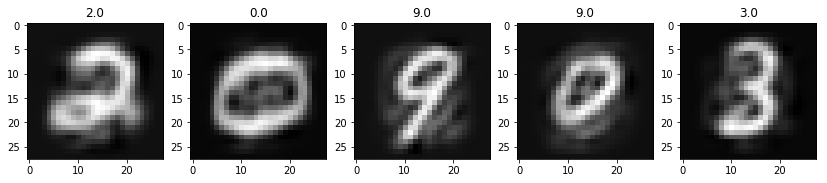

In [19]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(test_img[0:5], 1):
    subplot = fig.add_subplot(1, 7, i)
    img_ = img + test_img_mean
    plt.title('%s' % pred_test[i-1])
    plt.imshow(img_.reshape((28,28)) + test_img_mean.reshape((28,28)), cmap='gray');

## Готовим файл для отправки

In [20]:
test_img.shape

(28000, 784)

In [24]:
pred_test=[int(x) for x in pred_test]

In [25]:
with open('submit.txt', 'w') as dst:
    dst.write('ImageId,Label\n')
    for i, p in enumerate(pred_test, 1):
        dst.write('%s,%s\n' % (i, p))

In [26]:
!head submit.txt

"head" ­Ґ пў«пҐвбп ў­гваҐ­­Ґ© Ё«Ё ў­Ґи­Ґ©
Є®¬ ­¤®©, ЁбЇ®«­пҐ¬®© Їа®Ја ¬¬®© Ё«Ё Ї ЄҐв­л¬ д ©«®¬.


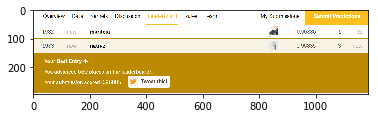

In [30]:
img = cv2.imread('./result.png')
%matplotlib inline
from matplotlib import pyplot as plt
plt.imshow(img)

In [32]:
#Your submission scored 0.96885